In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from pathlib import Path

# ---------- user settings ----------
EXCEL_PATH    = Path(r"/mnt/data/CVA&DVA_python.xlsx")  # adjust
S0            = 100        # spot & cap
MU            = 0.05
SIGMA         = 0.20
T_YEARS       = 1.0
N_STEPS       = 10_000     # ← granularity bump
N_PATHS       = 50_000
RISK_FREE     = 0.02
RECOVERY_BANK = 0.40
RECOVERY_CPTY = 0.40
SHEET_SPREADS = "ESTIMATING PD"


In [2]:
#Capped-GBM Simulator#
def simulate_capped_gbm(S0, mu, sigma, T, n_steps, n_paths, cap):
    dt      = T / n_steps
    nudt    = (mu - 0.5 * sigma**2) * dt
    sigsdt  = sigma * np.sqrt(dt)
    Z       = np.random.standard_normal((n_paths, n_steps))
    log_ret = nudt + sigsdt * Z
    log_S   = np.cumsum(np.hstack([np.zeros((n_paths,1)), log_ret]), axis=1)
    S       = S0 * np.exp(log_S)
    return np.minimum(S, cap)

print("Simulating paths …")
S_paths   = simulate_capped_gbm(S0, MU, SIGMA, T_YEARS, N_STEPS, N_PATHS, cap=S0)
time_grid = np.linspace(0, T_YEARS, N_STEPS+1)


Simulating paths …


In [3]:
#Exposure Metrics (EE, EPE, ENE, EFE + CIs)#
MTM = S_paths - S0                     # simple forward payoff
EE  = MTM.mean(0)
EPE = np.maximum(MTM, 0).mean(0)
ENE = np.minimum(MTM, 0).mean(0)
EFE = np.maximum.accumulate(EPE)

alpha95 = norm.ppf(0.975)
alpha99 = norm.ppf(0.995)
std_EE  = MTM.std(0, ddof=1) / np.sqrt(N_PATHS)
ci95_EE = (EE - alpha95*std_EE, EE + alpha95*std_EE)
ci99_EE = (EE - alpha99*std_EE, EE + alpha99*std_EE)


In [5]:
from pathlib import Path

# Point to your real file
EXCEL_PATH = Path(r"F:\credit risk\CVA AND DVA PROJECT\CVA&DVA.xlsx")

# Optional sanity-check
assert EXCEL_PATH.is_file(), f"File not found: {EXCEL_PATH}"
print("Found:", EXCEL_PATH)


Found: F:\credit risk\CVA AND DVA PROJECT\CVA&DVA.xlsx


In [8]:
# Peek at the raw headers in 'ESTIMATING PD'
tmp = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_SPREADS, nrows=0)
print(list(tmp.columns))


['Unnamed: 0', 'Time steps ', 'Credit Spread(Counterparty)', 'implied pd(counterparty)', 'PD ', 'SURVIVAL PROBABILITY', 'Bank Credit Spread (bps)', 'implied pd(bank)', 'PD .1', 'SURVIVAL PROBABILITY.1', 'Unnamed: 10', 'Recovery Rate ', 0.6]


In [13]:
# ──────────────────────────────────────────────────────────────
# 4.  Load Credit-Spread Sheet → PD & Survival  (fixed interp)
# ──────────────────────────────────────────────────────────────
spread_df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_SPREADS)
spread_df.columns = [str(c).strip() for c in spread_df.columns]

# map your headers to Tenor/BankSpread/CptySpread
rename_map = {
    'Time steps':                   'Tenor',
    'Time steps ':                  'Tenor',
    'Credit Spread(Counterparty)':  'CptySpread',
    'Bank Credit Spread (bps)':     'BankSpread',
}
spread_df = spread_df.rename(columns=lambda c: rename_map.get(c, c))

cols = ['Tenor', 'BankSpread', 'CptySpread']
missing = [c for c in cols if c not in spread_df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# keep only the needed columns and coerce numeric
spread_df = (spread_df[cols]
               .apply(pd.to_numeric, errors='coerce')
               .dropna())

# convert bps→decimal if values >1
for col in ['BankSpread','CptySpread']:
    spread_df[col] = np.where(spread_df[col].abs()>1,
                               spread_df[col]/10_000,
                               spread_df[col])

# bootstrap hazards & survival
def hazard(s,R): return s/(1-R)
haz_bank = hazard(spread_df['BankSpread'], RECOVERY_BANK)
haz_cpty = hazard(spread_df['CptySpread'], RECOVERY_CPTY)

# turn everything into numpy arrays
tenor_arr    = spread_df['Tenor'].to_numpy()
haz_bank_arr = haz_bank.to_numpy()
haz_cpty_arr = haz_cpty.to_numpy()

dt = np.diff(np.insert(tenor_arr, 0, 0))
surv_bank = np.exp(-np.cumsum(haz_bank_arr * dt))
surv_cpty = np.exp(-np.cumsum(haz_cpty_arr * dt))
pd_bank   = 1 - surv_bank
pd_cpty   = 1 - surv_cpty

# ─── FIXED INTERPOLATION ───────────────────────────────────────
# now tenor_arr, pd_bank and pd_cpty are plain numpy arrays:
pd_bank_grid = np.interp(time_grid, tenor_arr, pd_bank,
                         left=0, right=pd_bank[-1])
pd_cpty_grid = np.interp(time_grid, tenor_arr, pd_cpty,
                         left=0, right=pd_cpty[-1])

dpd_bank = np.diff(np.insert(pd_bank_grid, 0, 0))
dpd_cpty = np.diff(np.insert(pd_cpty_grid, 0, 0))


In [17]:
import re

# ──────────────────────────────────────────────────────────────
# Dynamic column detection in your ESTIMATING PD sheet
# ──────────────────────────────────────────────────────────────
spread_df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_SPREADS)
# clean whitespace
spread_df.columns = [str(c).strip() for c in spread_df.columns]

# helper to find a single column matching a pattern
def find_col(patterns, cols):
    """Return the first column name containing ANY of the substrings in patterns (case-insensitive)."""
    for p in patterns:
        rx = re.compile(p, re.I)
        for c in cols:
            if rx.search(c):
                return c
    raise KeyError(f"No column matching {patterns!r}")

cols = spread_df.columns.tolist()
# detect them by keyword cues
tenor_col       = find_col([r"time", r"tenor", r"matur"], cols)
bankspread_col  = find_col([r"bank", r"credit spread"], cols)
cptyspread_col  = find_col([r"counterparty", r"cpty"], cols)

print("Detected columns:")
print(" Tenor      →", tenor_col)
print(" BankSpread →", bankspread_col)
print(" CptySpread →", cptyspread_col)

# now rename just those three
spread_df = spread_df.rename(columns={
    tenor_col:      "Tenor",
    bankspread_col: "BankSpread",
    cptyspread_col: "CptySpread"
})

# continue as before…
spread_df = (spread_df[["Tenor","BankSpread","CptySpread"]]
               .apply(pd.to_numeric, errors="coerce")
               .dropna())

# bps → decimal if needed
for col in ["BankSpread","CptySpread"]:
    spread_df[col] = np.where(spread_df[col].abs()>1,
                              spread_df[col]/10_000,
                              spread_df[col])

# compute hazards
def hazard(s, R): return s/(1-R)
haz_bank = hazard(spread_df["BankSpread"], RECOVERY_BANK)
haz_cpty = hazard(spread_df["CptySpread"], RECOVERY_CPTY)

# build survival arrays and interpolate onto time_grid…
# (same as the last snippet)


Detected columns:
 Tenor      → Time steps
 BankSpread → Bank Credit Spread (bps)
 CptySpread → Credit Spread(Counterparty)


In [18]:
import re

# ──────────────────────────────────────────────────────────────
# 4.5 → 5. CVA & DVA pipeline with dynamic column lookup
# ──────────────────────────────────────────────────────────────

# 1️⃣  Read in and clean headers
spread_df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_SPREADS)
spread_df.columns = [str(c).strip() for c in spread_df.columns]

# 2️⃣  Dynamic detection helpers
def find_col(patterns, cols):
    for p in patterns:
        rx = re.compile(p, re.I)
        for c in cols:
            if rx.search(c):
                return c
    raise KeyError(f"No column matching {patterns}")

cols = spread_df.columns.tolist()
tenor_col      = find_col([r"time\s*steps?", r"tenor", r"matur"], cols)
bankspread_col = find_col([r"bank", r"credit spread"], cols)
cptyspread_col = find_col([r"counterparty", r"cpty"], cols)

# 3️⃣  Rename to canonical names
spread_df = spread_df.rename(columns={
    tenor_col:      "Tenor",
    bankspread_col: "BankSpread",
    cptyspread_col: "CptySpread"
})

# 4️⃣  Keep & coerce numeric
spread_df = (spread_df[["Tenor","BankSpread","CptySpread"]]
               .apply(pd.to_numeric, errors="coerce")
               .dropna())

# 5️⃣  Convert bps→decimal if values look >1
for c in ["BankSpread","CptySpread"]:
    spread_df[c] = np.where(spread_df[c].abs()>1,
                             spread_df[c]/10_000,
                             spread_df[c])

# 6️⃣  Bootstrap hazards
def hazard(s, R): return s/(1-R)
haz_bank = hazard(spread_df["BankSpread"], RECOVERY_BANK)
haz_cpty = hazard(spread_df["CptySpread"], RECOVERY_CPTY)

# 7️⃣  Raw survival at tenor points
tenor_arr      = spread_df["Tenor"].to_numpy()
haz_bank_arr   = haz_bank.to_numpy()
haz_cpty_arr   = haz_cpty.to_numpy()
dt             = np.diff(np.insert(tenor_arr, 0, 0))

surv_bank_raw  = np.exp(-np.cumsum(haz_bank_arr * dt))
surv_cpty_raw  = np.exp(-np.cumsum(haz_cpty_arr * dt))

# 8️⃣  Interpolate survivals onto the full sim grid
surv_bank_grid = np.interp(time_grid, tenor_arr, surv_bank_raw,
                           left=1.0, right=surv_bank_raw[-1])
surv_cpty_grid = np.interp(time_grid, tenor_arr, surv_cpty_raw,
                           left=1.0, right=surv_cpty_raw[-1])

# 9️⃣  Compute CVA & DVA
disc = np.exp(-RISK_FREE * time_grid)

CVA = (1 - RECOVERY_CPTY) * np.sum(
        EPE[1:]             # exposure
      * disc[1:]            # discount
      * dpd_cpty[1:]        # ΔPD of cpty
      * surv_bank_grid[1:]  # bank survival
)

DVA = (1 - RECOVERY_BANK) * np.sum(
        (-ENE[1:])          # positive magnitude of ENE
      * disc[1:]            # discount
      * dpd_bank[1:]        # ΔPD of bank
      * surv_cpty_grid[1:]  # cpty survival
)

print(f"CVA (with bank survival)       : {CVA:,.4f}")
print(f"DVA (with counterparty survival): {DVA:,.4f}")


CVA (with bank survival)       : 0.0000
DVA (with counterparty survival): 0.0695


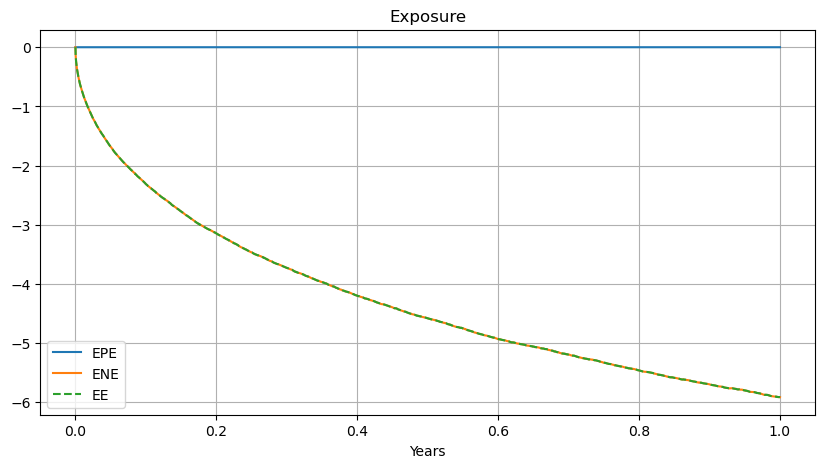

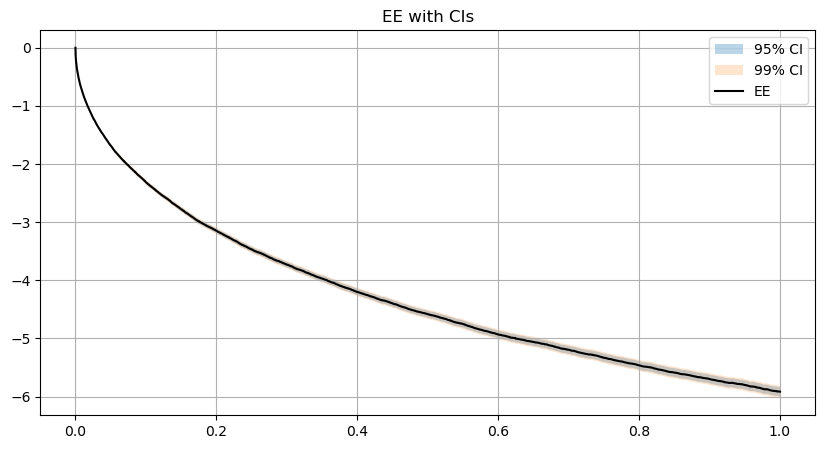

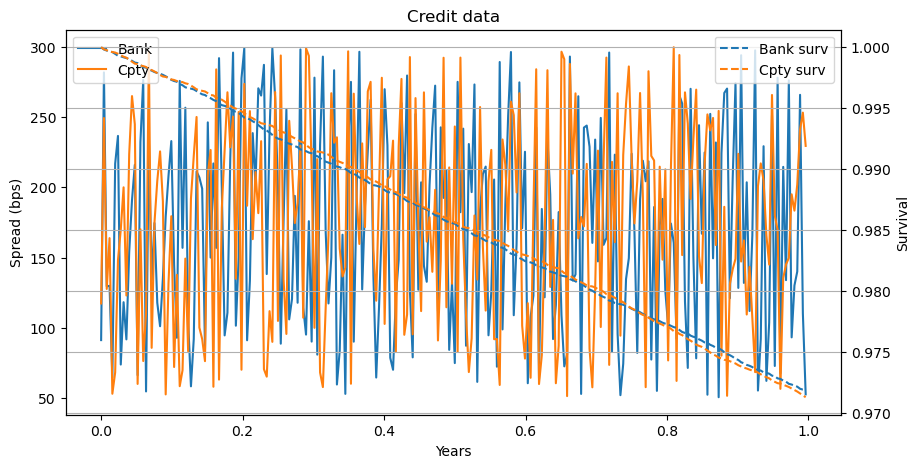

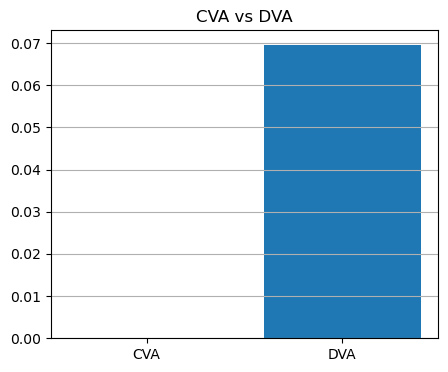

In [19]:
# Exposure profiles
plt.figure(figsize=(10,5))
plt.plot(time_grid, EPE, label="EPE")
plt.plot(time_grid, ENE, label="ENE")
plt.plot(time_grid, EE,  label="EE", linestyle="--")
plt.legend(); plt.grid(); plt.xlabel("Years"); plt.title("Exposure"); plt.show()

# EE confidence bands
plt.figure(figsize=(10,5))
plt.fill_between(time_grid, *ci95_EE, alpha=0.3, label="95% CI")
plt.fill_between(time_grid, *ci99_EE, alpha=0.2, label="99% CI")
plt.plot(time_grid, EE, color="black", label="EE")
plt.legend(); plt.grid(); plt.title("EE with CIs"); plt.show()

# Spreads & survival
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.set_xlabel("Years"); ax1.set_ylabel("Spread (bps)")
ax1.plot(tenor, spread_df['BankSpread']*10_000, label="Bank")
ax1.plot(tenor, spread_df['CptySpread']*10_000, label="Cpty")
ax1.legend(loc="upper left")
ax2 = ax1.twinx(); ax2.set_ylabel("Survival")
ax2.plot(tenor, surv_bank, "--", label="Bank surv")
ax2.plot(tenor, surv_cpty, "--", label="Cpty surv")
ax2.legend(loc="upper right"); plt.title("Credit data"); plt.grid(); plt.show()

# CVA vs DVA bar
plt.figure(figsize=(5,4))
plt.bar(["CVA","DVA"], [CVA, DVA]); plt.grid(axis="y"); plt.title("CVA vs DVA"); plt.show()
